In [83]:
import os
import numpy as np
import pandas as pd
# Pandas Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize

import json
import requests
import re
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline 

import folium
from folium import plugins
from folium.plugins import HeatMap

from sklearn.cluster import KMeans

print('Libraries Imported.')

Libraries Imported.


In [84]:
def process_demographic_csv_to_df(file_path):
    # Read csv to pandas df, skip 2 rows, set column 0 as index
    df = pd.read_csv(file_path, skiprows=2, index_col=0)
    # Drop last two columns (Arlington totals)
    df.drop(df.columns[-2:], axis=1, inplace=True)
    # Convert percentage to floats
    df['Percent'] = df['Percent'].str.rstrip('%').astype('float') / 100.0
    # Replace Total rows percent with count 
    df['Percent'].mask(df.index.str.contains('TOTAL'), df['Number'], inplace=True)
    # Drop number column 
    df.drop(columns=['Number'], inplace=True)
    # Rename percent to neighborhood name
    df.columns = [df.index.name]
    df.index.name = None
    # drop na 
    df.dropna(inplace=True)
    # Transpose df
    df = df.T
    return df

In [85]:
import os

CSV_DIR = r'data/demographics/csv/'

dfs = []
for file in os.listdir(CSV_DIR):
    df = process_demographic_csv_to_df(CSV_DIR+file)
    dfs.append(df)
arlington_demographics = pd.concat(dfs)
arlington_demographics.sort_index(inplace=True)
arlington_demographics

,TOTAL POPULATION,Total Non-Hispanic or Latino,White alone,Black or African-American alone,American Indian or Alaska Native alone,Asian alone,Native Hawaiian or Pacific Islander Alone,Some other Race alone,Two or more Races,Total Hispanic or Latino,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Male,Female,TOTAL HOUSEHOLDS,Family households:,Husband-wife family,Other family:,"Male householder, no wife present","Female householder, no husband present",Nonfamily households:,Householder living alone,Householder not living alone,1-person household,2-person household,3-person household,4-person household,5-person household,6-person household,7-or-more-person household,TOTAL HOUSING UNITS,Occupied Housing Units,Owner-Occupied,Renter-Occupied,Vacant Housing Units
Alcova Heights,"1,900",0.761,0.582,0.047,0.003,0.097,0.000,0.003,0.029,0.239,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,0.490,0.510,745,0.580,0.474,0.106,0.030,0.077,0.420,0.278,0.142,0.278,0.340,0.168,0.106,0.064,0.019,0.026,784,0.950,0.696,0.254,0.050
Arlington Forest,"2,223",0.927,0.823,0.017,0.001,0.047,0.004,0.001,0.034,0.073,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.506,0.494,834,0.685,0.613,0.072,0.018,0.054,0.315,0.207,0.108,0.207,0.317,0.194,0.211,0.049,0.013,0.008,852,0.979,0.823,0.156,0.021
Arlington Heights,"2,555",0.770,0.576,0.060,0.002,0.101,0.003,0.004,0.025,0.230,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.499,0.501,"1,032",0.529,0.414,0.115,0.029,0.086,0.471,0.326,0.145,0.326,0.309,0.167,0.102,0.044,0.020,0.033,1070,0.964,0.595,0.369,0.036
Arlington Ridge,"6,324",0.937,0.733,0.040,0.003,0.132,0.001,0.002,0.027,0.063,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.479,0.521,"3,549",0.352,0.313,0.039,0.012,0.026,0.648,0.492,0.156,0.492,0.343,0.090,0.051,0.016,0.006,0.002,3755,0.945,0.416,0.529,0.055
Arlington View,979,0.896,0.190,0.619,0.012,0.057,0.001,0.001,0.015,0.104,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.487,0.513,376,0.598,0.298,0.301,0.077,0.223,0.402,0.287,0.114,0.287,0.309,0.165,0.122,0.056,0.029,0.032,391,0.962,0.517,0.445,0.038
Arlingwood,366,0.959,0.888,0.019,0.005,0.025,0.000,0.008,0.014,0.041,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.478,0.522,136,0.809,0.750,0.059,0.029,0.029,0.191,0.162,0.029,0.162,0.382,0.140,0.243,0.066,0.007,0.000,148,0.919,0.851,0.068,0.081
Ashton Heights,"3,962",0.856,0.685,0.063,0.001,0.082,0.000,0.003,0.022,0.144,0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,0.521,0.479,"1,715",0.451,0.363,0.087,0.027,0.060,0.549,0.362,0.188,0.362,0.304,0.152,0.122,0.036,0.017,0.007,1777,0.965,0.385,0.580,0.035
Aurora Highlands,"8,725",0.907,0.680,0.082,0.003,0.113,0.000,0.001,0.028,0.093,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.491,0.509,"4,804",0.297,0.255,0.042,0.012,0.030,0.703,0.507,0.196,0.507,0.326,0.095,0.050,0.014,0.006,0.003,5514,0.871,0.124,0.747,0.129
Ballston - Virginia Square,"13,753",0.948,0.773,0.029,0.001,0.118,0.000,0.002,0.025,0.052,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,0.502,0.498,"8,218",0.240,0.203,0.038,0.014,0.023,0.760,0.514,0.245,0.514,0.363,0.083,0.031,0.007,0.001,0.001,8861,0.927,0.329,0.598,0.073
Barcroft,"3,477",0.632,0.497,0.050,0.002,0.057,0.001,0.003,0.022,0.368,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.529,0.471,"1,285",0.602,0.461,0.141,0.068,0.073,0.398,0.267,0.131,0.267,0.282,0.163,0.168,0.065,0.031,0.024,1327,0.968,0.518,0.451,0.032


In [86]:
columns = [
    'TOTAL POPULATION',
    'Under 5 years',
    '5 to 17 years',
    '18 to 24 years',
    '25 to 34 years',
    '35 to 44 years',
    '45 to 54 years',
    '55 to 64 years',
    '65 to 74 years',
    '75 to 84 years',
    '85 years and over',
    'TOTAL HOUSEHOLDS',
    'Family households:',
    'Nonfamily households:',
    'TOTAL HOUSING UNITS',
    'Occupied Housing Units',
    'Vacant Housing Units',
]

arlington_demographics = arlington_demographics[columns]
arlington_demographics

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,Family households:,Nonfamily households:,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,"1,900",0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,"1,285",0.602,0.398,1327,0.968,0.032


In [87]:
b1 = arlington_demographics['Under 5 years'] + arlington_demographics['5 to 17 years']
b2 = arlington_demographics['18 to 24 years'] + arlington_demographics['25 to 34 years']
b3 = arlington_demographics['35 to 44 years'] + arlington_demographics['45 to 54 years'] + arlington_demographics['55 to 64 years']
b4 = arlington_demographics['65 to 74 years'] + arlington_demographics['75 to 84 years'] + arlington_demographics['85 years and over']
arlington_demographics.insert(1, 'under 18 years old', b1)
arlington_demographics.insert(2, '18 to 34 years old', b2)
arlington_demographics.insert(3, '35 to 64 years old', b3)
arlington_demographics.insert(4, 'over 64 years old', b4)
arlington_demographics.drop(columns=[
    'Under 5 years',
    '5 to 17 years',
    '18 to 24 years',
    '25 to 34 years',
    '35 to 44 years',
    '45 to 54 years',
    '55 to 64 years',
    '65 to 74 years',
    '75 to 84 years',
    '85 years and over'], inplace=True)
arlington_demographics

/Users/ryaneudy/Documents/Workspace/Coursera_Capstone/venv/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,TOTAL POPULATION,under 18 years old,18 to 34 years old,35 to 64 years old,over 64 years old,TOTAL HOUSEHOLDS,Family households:,Nonfamily households:,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,"1,900",0.191,0.283,0.453,0.072,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.256,0.179,0.463,0.102,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.187,0.276,0.454,0.082,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.097,0.371,0.388,0.144,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.210,0.259,0.407,0.123,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.274,0.069,0.453,0.205,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.157,0.392,0.380,0.072,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.087,0.466,0.341,0.105,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.052,0.571,0.286,0.090,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.207,0.325,0.396,0.071,"1,285",0.602,0.398,1327,0.968,0.032


In [88]:
arlington_demographics.rename(columns={"Family households:": "family households", "Nonfamily households:": "nonfamily households"}, inplace=True)
arlington_demographics

/Users/ryaneudy/Documents/Workspace/Coursera_Capstone/venv/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,TOTAL POPULATION,under 18 years old,18 to 34 years old,35 to 64 years old,over 64 years old,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,"1,900",0.191,0.283,0.453,0.072,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.256,0.179,0.463,0.102,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.187,0.276,0.454,0.082,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.097,0.371,0.388,0.144,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.210,0.259,0.407,0.123,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.274,0.069,0.453,0.205,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.157,0.392,0.380,0.072,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.087,0.466,0.341,0.105,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.052,0.571,0.286,0.090,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.207,0.325,0.396,0.071,"1,285",0.602,0.398,1327,0.968,0.032


In [89]:
arlington_demographics['TOTAL POPULATION'] = arlington_demographics['TOTAL POPULATION'].str.replace(',', '').astype('float')
arlington_demographics['TOTAL HOUSEHOLDS'] = arlington_demographics['TOTAL HOUSEHOLDS'].str.replace(',', '').astype('float')
arlington_demographics['TOTAL HOUSING UNITS'] = arlington_demographics['TOTAL HOUSING UNITS'].str.replace(',', '').astype('float')
arlington_demographics

<ipython-input-89-7dc4d08dd05d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arlington_demographics['TOTAL POPULATION'] = arlington_demographics['TOTAL POPULATION'].str.replace(',', '').astype('float')
<ipython-input-89-7dc4d08dd05d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arlington_demographics['TOTAL HOUSEHOLDS'] = arlington_demographics['TOTAL HOUSEHOLDS'].str.replace(',', '').astype('float')
<ipython-input-89-7dc4d08dd05d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,TOTAL POPULATION,under 18 years old,18 to 34 years old,35 to 64 years old,over 64 years old,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,1900.0,0.191,0.283,0.453,0.072,745.0,0.580,0.420,784.0,0.950,0.050
Arlington Forest,2223.0,0.256,0.179,0.463,0.102,834.0,0.685,0.315,852.0,0.979,0.021
Arlington Heights,2555.0,0.187,0.276,0.454,0.082,1032.0,0.529,0.471,1070.0,0.964,0.036
Arlington Ridge,6324.0,0.097,0.371,0.388,0.144,3549.0,0.352,0.648,3755.0,0.945,0.055
Arlington View,979.0,0.210,0.259,0.407,0.123,376.0,0.598,0.402,391.0,0.962,0.038
Arlingwood,366.0,0.274,0.069,0.453,0.205,136.0,0.809,0.191,148.0,0.919,0.081
Ashton Heights,3962.0,0.157,0.392,0.380,0.072,1715.0,0.451,0.549,1777.0,0.965,0.035
Aurora Highlands,8725.0,0.087,0.466,0.341,0.105,4804.0,0.297,0.703,5514.0,0.871,0.129
Ballston - Virginia Square,13753.0,0.052,0.571,0.286,0.090,8218.0,0.240,0.760,8861.0,0.927,0.073
Barcroft,3477.0,0.207,0.325,0.396,0.071,1285.0,0.602,0.398,1327.0,0.968,0.032


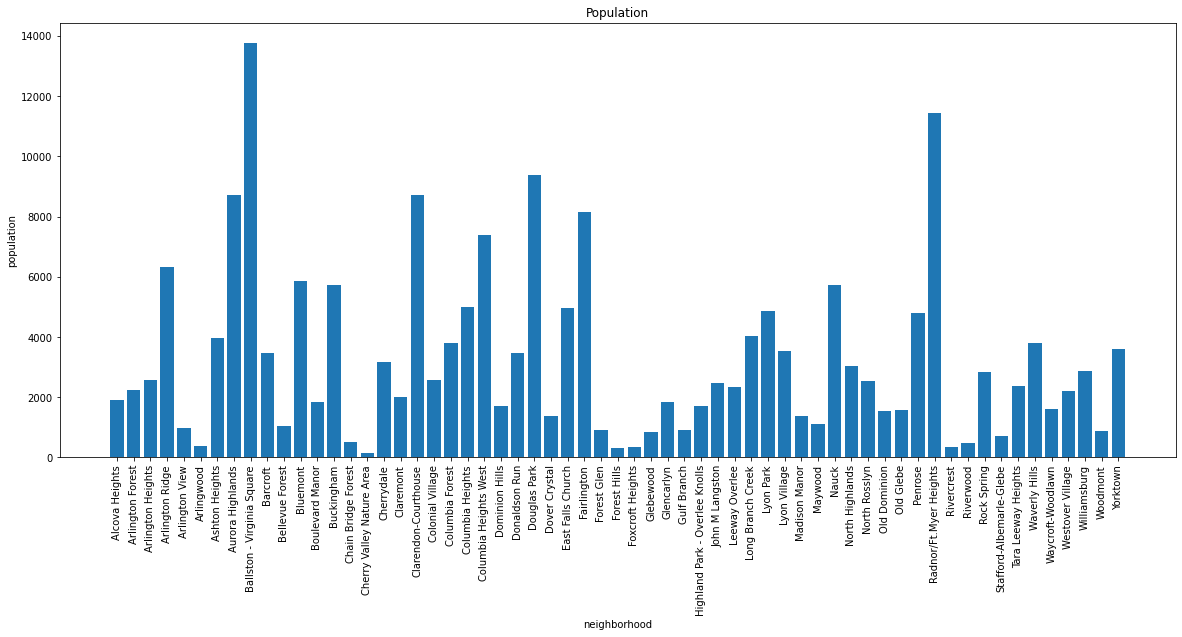

In [90]:
x = list(arlington_demographics.index)
population = arlington_demographics['TOTAL POPULATION']
population

plt.figure(figsize=(20, 8))
plt.bar(x, population)
plt.title("Population")
plt.ylabel("population")
plt.xlabel("neighborhood")
plt.xticks(rotation='vertical')
plt.show()

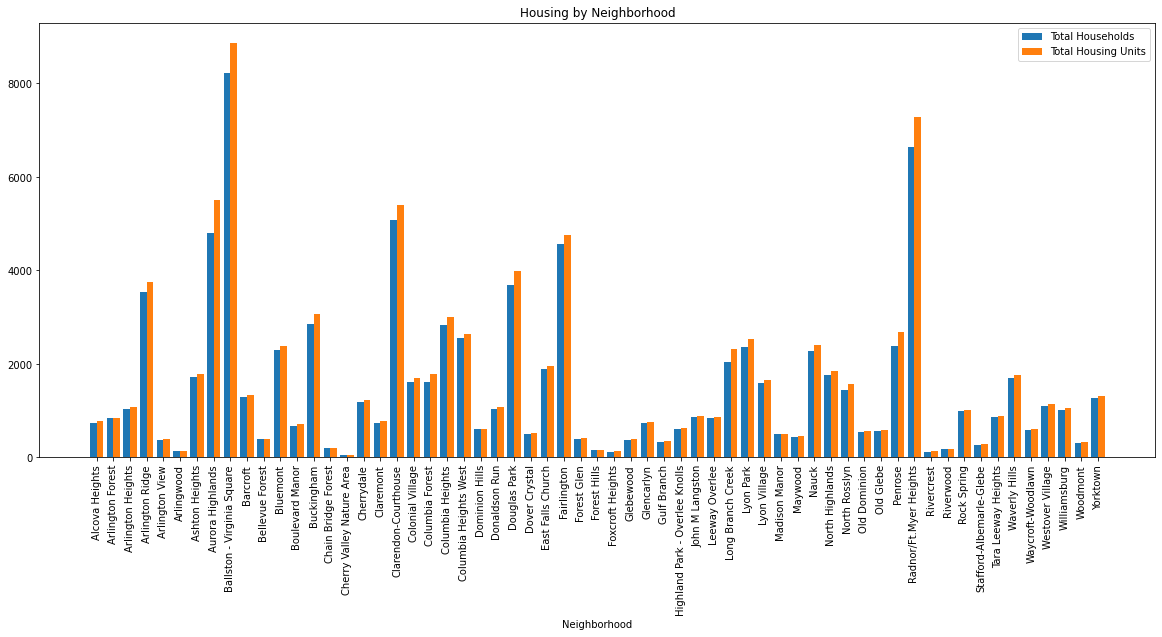

In [91]:
x = list(arlington_demographics.index)
households = arlington_demographics['TOTAL HOUSEHOLDS']
housing = arlington_demographics['TOTAL HOUSING UNITS']
housing

ind = np.arange(len(x))
plt.figure(figsize=(20, 8))
plt.bar(ind, households, 0.40, label='Total Households')
plt.bar(ind+0.40, housing, 0.40, label='Total Housing Units')
plt.title("Housing by Neighborhood")
plt.xlabel("Neighborhood")
plt.xticks(ind+0.40/2, x, rotation='vertical')
plt.legend(loc='best')
plt.show()

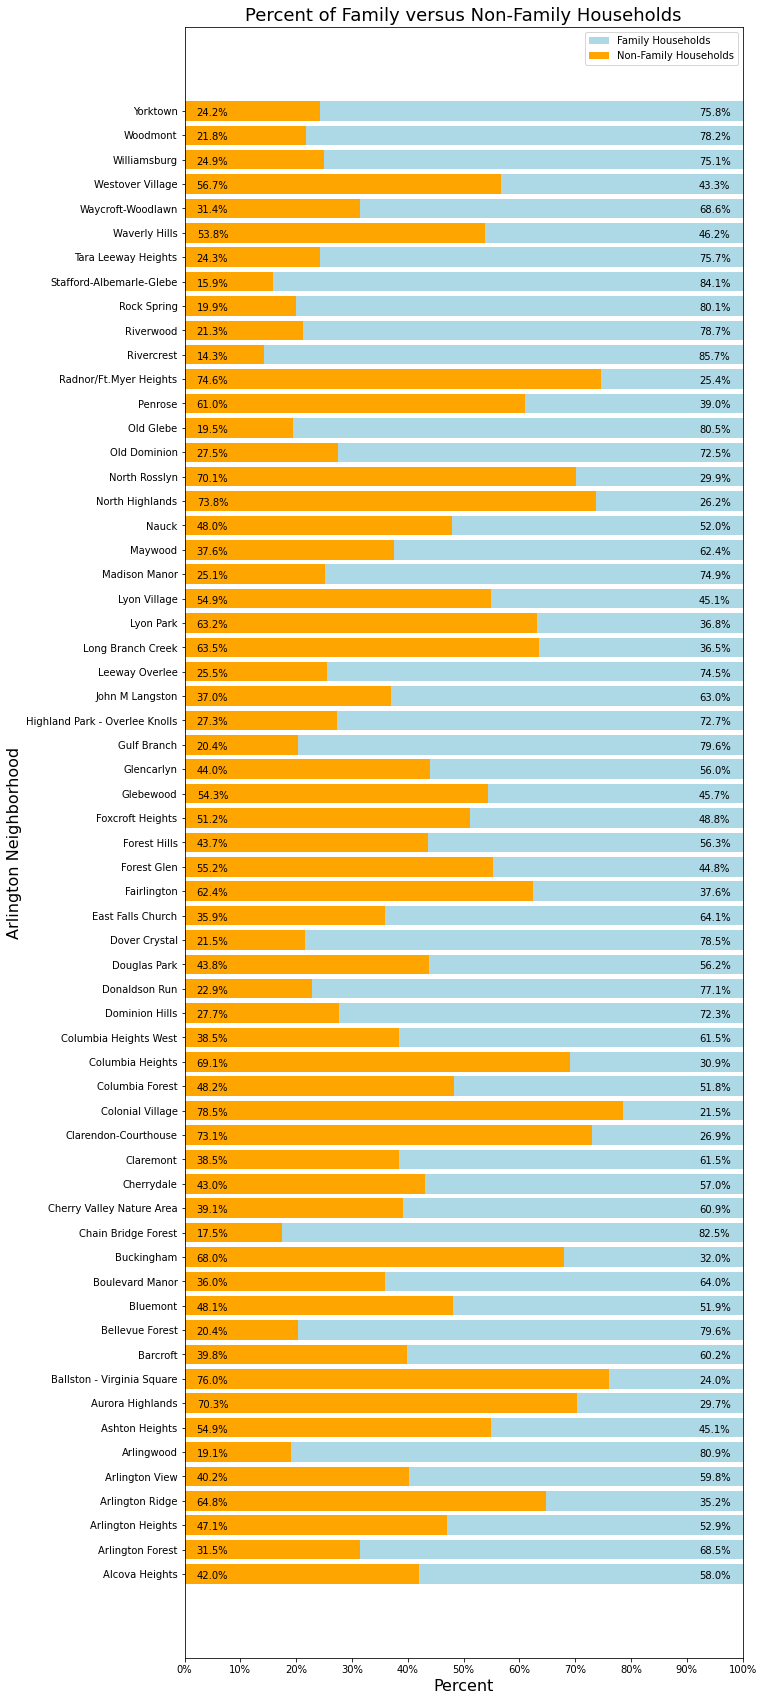

In [143]:
x = np.arange(0, 110, 10)
n = list(arlington_demographics.index)
family_households = arlington_demographics['family households'] * 100
nonfamily_households = arlington_demographics['nonfamily households'] * 100

fig, ax = plt.subplots(figsize=(10,30))
rects1 = ax.barh(n, family_households, label='Family Households', left=nonfamily_households, color='lightblue')
rects2 = ax.barh(n, nonfamily_households, label='Non-Family Households', color='orange')


ax.set_xticks(x)
ax.set_xticklabels([str(p)+'%' for p in x])
ax.set_title("Percent of Family versus Non-Family Households", fontsize=18)
ax.set_ylabel("Arlington Neighborhood", fontsize=16)
ax.set_xlabel("Percent", fontsize=16)

ax.set_xlim(0,100)
ax.legend()


for fam, non in zip(rects1, rects2):
    ax.annotate('{}%'.format(round(non.get_width(),2)),
                xy=(5, non.get_y()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    ax.annotate('{}%'.format(round(fam.get_width(),2)),
                xy=(95, non.get_y()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


plt.show()

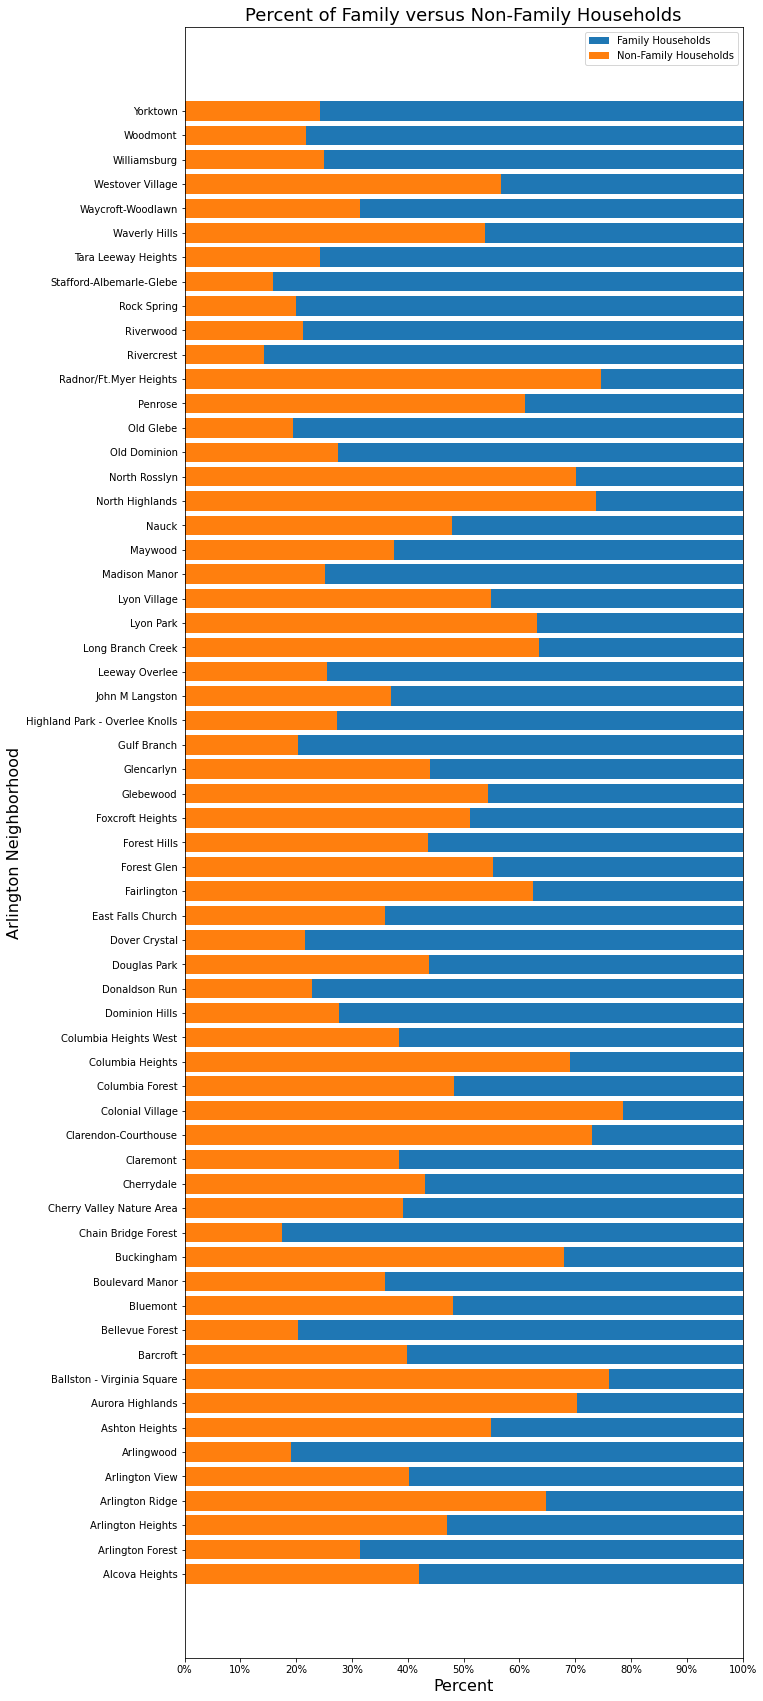

In [100]:
x = list(arlington_demographics.index)
family_households = arlington_demographics['family households'] * 100
nonfamily_households = arlington_demographics['nonfamily households'] * 100

plt.figure(figsize=(10, 30))
plt.barh(x, family_households, label='Family Households', left=nonfamily_households)
plt.barh(x, nonfamily_households, label='Non-Family Households')
plt.title("Percent of Family versus Non-Family Households", fontsize=18)
plt.ylabel("Arlington Neighborhood", fontsize=16)
plt.xlabel("Percent", fontsize=16)
plt.xlim(0,100)
plt.xticks(t, [str(p)+'%' for p in t], fontsize=10)
plt.legend(loc='best')
plt.show()

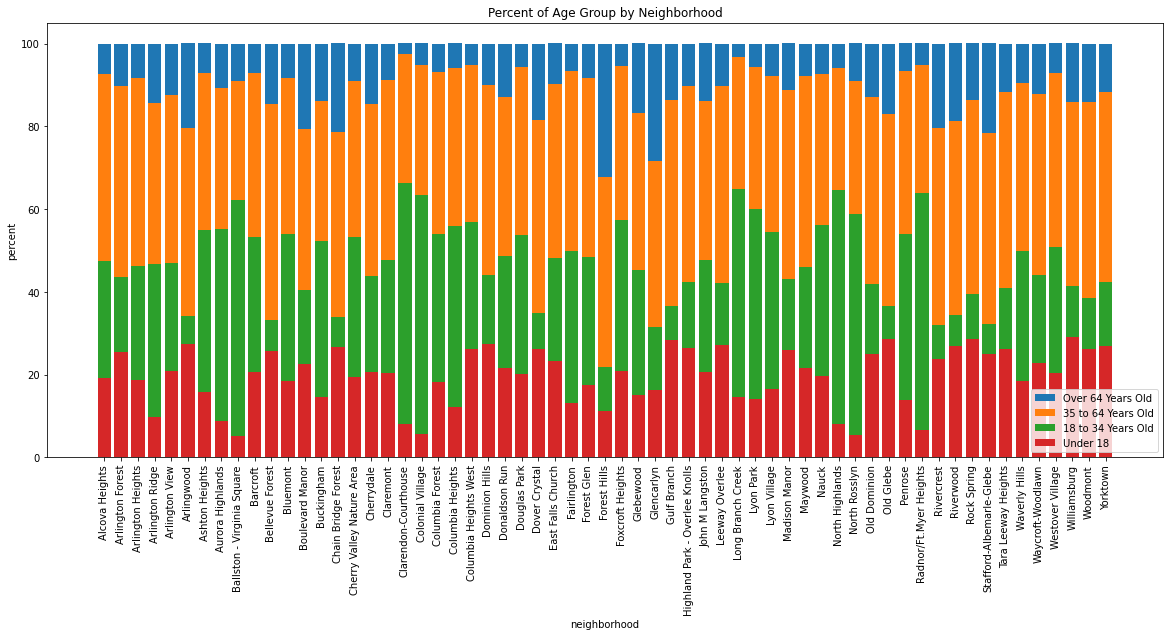

In [94]:
x = list(arlington_demographics.index)
under_18 = arlington_demographics['under 18 years old'] * 100
_18_to_34 = arlington_demographics['18 to 34 years old'] * 100
_35_to_64 = arlington_demographics['35 to 64 years old'] * 100
over_64 = arlington_demographics['over 64 years old'] * 100

plt.figure(figsize=(20, 8))
plt.bar(x, over_64, label='Over 64 Years Old', bottom=under_18+_18_to_34+_35_to_64)
plt.bar(x, _35_to_64, label='35 to 64 Years Old', bottom=under_18+_18_to_34)
plt.bar(x, _18_to_34, label='18 to 34 Years Old', bottom=under_18)
plt.bar(x, under_18, label='Under 18')
plt.title("Percent of Age Group by Neighborhood")
plt.ylabel("percent")
plt.xlabel("neighborhood")
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.show()